# 偶极矩的测定

实验一开始时需要根据环己烷和乙酸乙酯的密度、摩尔质量来计算需要有多少体积的乙酸乙酯配成溶液，才能达到给定的摩尔分数。

In [1]:
rho_hr = 0.77855 # 环己烷密度
M_hr = 84.16 # 环己烷摩尔质量
rho_yi = 0.9003 # 乙酸乙酯密度
M_yi = 88.12 # 乙酸乙酯摩尔质量

In [2]:
def V(v):
    # 给定一个乙酸乙酯体积v，计算乙酸乙酯摩尔浓度，注意总量是25
    A = rho_hr * (25 - v)  / M_hr
    B = rho_yi * v / M_yi
    return B / (A + B)


In [3]:
from scipy.optimize import root_scalar
x_is = [0.05, 0.10, 0.15, 0.20]
res = []
for x_i in x_is:

    def VV(v):
        return V(v) - x_i
    r = root_scalar(VV, bracket=[-1, 25])
    res.append(r.root)
res # 此数据为应该量取的环己烷体积，单位mL

[1.1371974254356354, 2.285248827767572, 3.4443103457464983, 4.614541127375976]

## 测定数据


In [4]:
import pandas as pd
import os.path
data_path = os.path.join('..', '数据','偶极矩')
weight_table = pd.read_csv(os.path.join(data_path, '重量.csv'), index_col=0)
weight_table

,空容量瓶,乙酸,环己烷
组别,,,
0.05,17.0974,17.8990,36.3779
0.10,28.9117,30.6767,48.3565
0.15,24.7731,27.6383,44.2263
0.20,24.6930,28.4962,44.4122


In [5]:
n_table = pd.read_csv(os.path.join(data_path, '折射率.csv'), index_col=0)
n_table

,n1,n2
组别,,
水,1.3610,1.3600
0.05,1.4230,1.4230
0.10,1.4198,1.4210
0.15,1.4188,1.4189
0.20,1.4180,1.4180


In [6]:
rho_table = pd.read_csv(os.path.join(data_path, '密度.csv'), index_col=0)
rho_table

,空瓶质量,5mL质量
组别,,
水,9.1749,14.0500
0.05,9.1749,13.0726
0.10,9.1749,13.0932
0.15,9.1752,13.1171
0.20,9.1850,13.2194


In [7]:
c_table = pd.read_csv(os.path.join(data_path, '电容.csv'), index_col=0)
c_table

,电容1,电容2
组别,,
空气,5.56,5.56
环己烷,8.14,8.14
0.05,8.39,8.38
0.10,8.80,8.78
0.15,8.88,8.89
0.20,8.93,8.92


## 按照实验指导书作图

### 计算实际物质的量分数

实际的物质的量分数计算公式为

$$
n = \frac{m_1 - m_0}{M} 
$$

$$
n' = \frac{m_2 - m_1}{M'} 
$$

$$
w = \frac{n}{n + n'}
$$

这里$n$为乙酸乙酯物质的量，$n'$为环己烷物质的量，$m_0, m_1, m_2$分别为先后测定的三个数值，也就是空容量瓶、乙酸、环己烷

In [8]:
def get_w(weight_table: pd.DataFrame) -> pd.DataFrame:
    n = (weight_table['乙酸'] - weight_table['空容量瓶']) / M_yi
    n_ = (weight_table['环己烷'] - weight_table['乙酸']) / M_hr
    w = n / (n + n_)
    return pd.DataFrame(
        {
            "x": w
        }
    )
w = get_w(weight_table)
w

,x
组别,
0.05,0.039782
0.10,0.087046
0.15,0.141605
0.20,0.185811


### 绘制折射率$n$与$x_2$的关系，求出$\gamma$值

In [9]:
# 先计算平均值，也就是4组的n
n = (n_table['n1'] + n_table['n2']) / 2
n = n[1:]
n

组别
0.05    1.42300
0.10    1.42040
0.15    1.41885
0.20    1.41800
dtype: float64

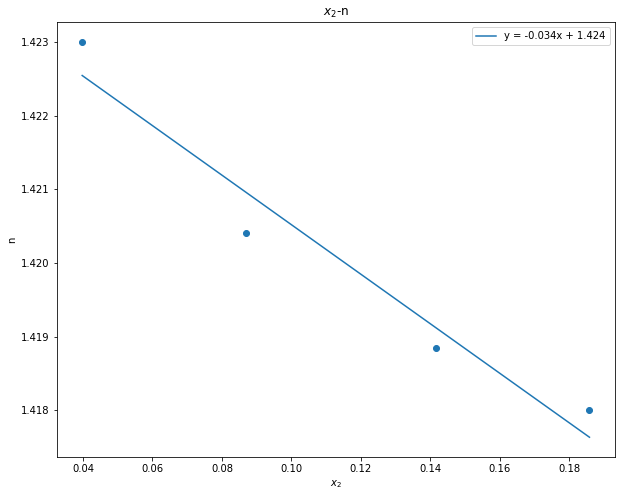

In [10]:
# 绘制图像（线性回归）
from matplotlib import pyplot as plt
import matplotlib
from sklearn import linear_model
import numpy as np
matplotlib.rcParams['figure.figsize'] = [10, 8]
model = linear_model.LinearRegression()
figure1_reg = model.fit(np.array(w['x']).reshape(-1, 1), n)
x_pred = np.linspace(w['x'].iloc[0], w['x'].iloc[3], 100).reshape(-1, 1)
y_pred = figure1_reg.predict(x_pred)
plt.plot(x_pred, y_pred, label='y = %.3fx + %.3f' % (figure1_reg.coef_[0], figure1_reg.intercept_))
plt.scatter(w['x'], n)
plt.xlabel('$x_2$')
plt.ylabel('n')
plt.title('$x_2$-n')
plt.legend()

#### 计算$\gamma$值

由于
$$
n_{溶} = n_1(1 + \gamma x_2)
$$

而回归方程为
$$
y_{n_溶} = ax_2 + b
$$

对照系数可以计算得：

$$
n_1 = b \qquad \gamma = \frac{a}{b}
$$

In [11]:
gamma = figure1_reg.coef_[0] / figure1_reg.intercept_
gamma

-0.023617939251635446

In [12]:
n1 = figure1_reg.intercept_
n1

1.4238814570530742

### 计算环己烷以及各种溶液的密度$\rho$，作$\rho-x_2$图，求出$\beta$值

In [13]:
rho = rho_table['5mL质量'] - rho_table['空瓶质量']
rho = rho[1:] / 5
rho # 单位：g/mL

组别
0.05    0.77954
0.10    0.78366
0.15    0.78838
0.20    0.80688
dtype: float64

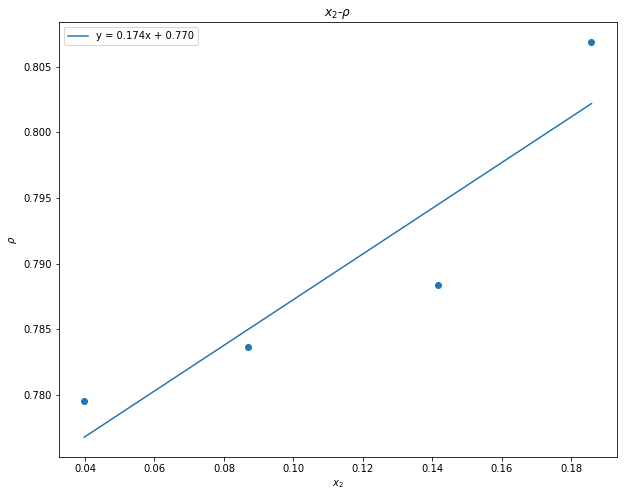

In [14]:
figure2_reg = model.fit(np.array(w['x']).reshape(-1, 1), rho)
x_pred = np.linspace(w['x'].iloc[0], w['x'].iloc[3], 100).reshape(-1, 1)
y_pred = figure2_reg.predict(x_pred)
plt.plot(x_pred, y_pred, label='y = %.3fx + %.3f' % (figure2_reg.coef_[0], figure2_reg.intercept_))
plt.scatter(w['x'], rho)
plt.xlabel(r'$x_2$')
plt.ylabel(r'$\rho$')
plt.title(r'$x_2$-$\rho$')
plt.legend()

利用公式
$$
\beta = \frac{a}{b}
$$

计算$\beta$。

In [15]:
beta = figure2_reg.coef_[0] / figure2_reg.intercept_
beta

0.22594694342090157

### 计算介电常数

计算公式：
$$
C_{空气} = \frac{C'_{标} - C'_{空气}}{\epsilon_{标} - 1}
$$

其中

$$
\epsilon _{标} = 2.052 - 1.55 \times 10^{-3} T
$$

$T$为温度，单位：摄氏度。

$$
C_d = C'_{标} - \epsilon _{标} \cdot C_{空气}
$$

介电常数

$$
\mathbf{\epsilon} = \frac{C'_{测定值} - C_d}{C_{空气}}
$$

In [16]:
def eps_std(t):
    return 2.052 - 1.55 * 10 ** -3 * t
c_table['电容'] = (c_table['电容1'] + c_table['电容2']) / 2
T = 20 # 做实验的时候的室温
c_air = (c_table['电容']['环己烷'] - c_table['电容']['空气']) / (eps_std(T) - 1)
c_air # pF

2.526934378060726

In [17]:
c_d = c_table['电容']['环己烷'] - eps_std(T) * c_air
c_d # pF

3.033065621939273

In [18]:
eps = (c_table['电容'] - c_d) / c_air
eps

组别
空气      1.000000
环己烷     2.021000
0.05    2.117955
0.10    2.278229
0.15    2.315824
0.20    2.331653
Name: 电容, dtype: float64

In [19]:
eps = np.array(eps[2:])
eps

array([2.11795543, 2.27822868, 2.31582364, 2.3316531 ])

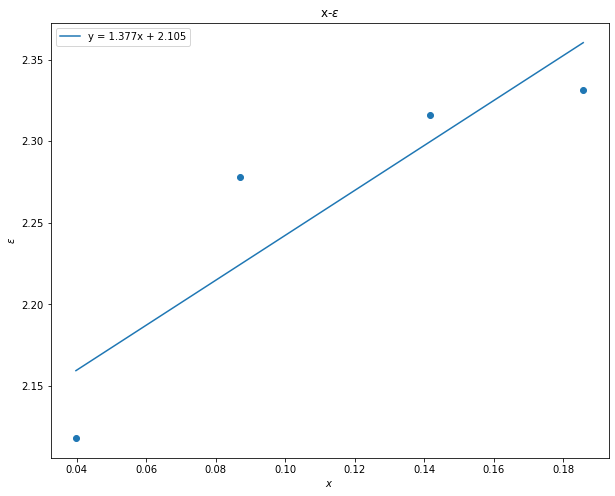

In [20]:

figure3_reg = model.fit(np.array(w['x']).reshape(-1, 1), eps)
x_pred = np.linspace(w['x'].iloc[0], w['x'].iloc[3], 100).reshape(-1, 1)
y_pred = figure3_reg.predict(x_pred)
plt.plot(x_pred, y_pred, label='y = %.3fx + %.3f' % (figure3_reg.coef_[0], figure3_reg.intercept_))
plt.scatter(w['x'], eps)
plt.xlabel(r'$x$')
plt.ylabel(r'$\epsilon$')
plt.title(r'x-$\epsilon$')
plt.legend()

In [21]:
alpha = figure3_reg.coef_[0] / figure3_reg.intercept_
alpha

0.6544842011035014

# 计算偶极矩$\mu$值

## 先计算$P_2^\infty$和$R_2^\infty$

$$
P_2^\infty = \frac{3\alpha \epsilon _1}{(\epsilon _1 + 2)^2} \frac{M_1}{\rho_1} + \frac{\epsilon _1 - 1}{\epsilon _1 + 2} \frac{M_2 - \beta M_1}{\rho_1}
$$

$$
R_2^\infty = \frac{n_1^2 - 1}{n_1^2 + 2} \frac{M_2 - \beta M_1}{\rho_1} + \frac{6n_1^2M_1 \gamma}{(n_1^2 + 2)^2 \rho_1}
$$

## 根据公式计算$\mu$

$$
\mu = 0.0128 \sqrt{(P_2^\infty - R_2^\infty)T}
$$


In [22]:
eps1 = eps_std(T)
M1 = M_hr # 溶剂的摩尔质量为环己烷的摩尔质量
rho1 = rho_hr # 溶剂的密度为环己烷的密度
n1 # 已经在折射率部分计算过
M2 = M_yi # 乙酸乙酯

In [23]:
aux = (M2 - beta * M1) / rho1
aux

88.76026618932237

In [24]:
n1

1.4238814570530742

In [25]:
P = 3 * alpha * eps1 / ((eps1 + 2) ** 2) * M1 / rho1 + (eps1 - 1) / (eps1 + 2) * aux
P

49.067768874702374

In [26]:
n12 = n1 * n1
R = (n12 - 1) / (n12 + 2) * aux + (6 * n12 * M1 * gamma) / ((n12 + 2) ** 2 * rho1)
R

20.728893493488076

In [27]:
import math
mu = 0.0128 * math.sqrt((P - R) * T)
mu

1.362797320581186

$$
\mu = 1.363
$$

# 计算真值和相对误差

In [28]:
mu_real = 1.79 # D
(mu_real - mu) / mu_real

0.23866071475911393